<img src="https://www.rochester.edu/assets/images/ur-logo.svg">

# <center>[CSC 249/449: Machine Vision](https://www.cs.rochester.edu/~cxu22/t/249S22/)</center>


1. Make sure you fill in all cells contain `YOUR CODE HERE` or `YOUR ANSWER HERE`.
2. After you finished, `Restart the kernel & run` all cell in order.
---------


In [1]:
import numpy as np
import csc249

# Camera Model


In this assignment, we aim to estimate the projection matrix $\mathbf{P}$ of the camera model with calibrated data points and compute the camera center from $\mathbf{P}$

To estimate the projection matrix, you'll only need to implement one function: `projection`: project world coordinates point to pixel coordinates

The matrix is estimated by minimizing the projection error:
$$
P = \underset{\mathbf{P}}{\arg\min}\sum_{i=1}^N (\mathbf{P}\mathbf{x}_{3d}^i-\mathbf{x}_{2d}^i )^2 .
$$

Finally, we can decompose the projection matrix as  $\mathbf{P}=\mathbf{K}\mathbf{R}[\mathbf{I}|-\mathbf{C}]$ and find the camera location in the world coordinates.

## Projection

As shown in the lecture slide, the pixel coordinates $x_i, y_i$ is the projection from world coordinates $X_i = [X_i, Y_i, Z_i, 1]$ throught the camera model $P_p \in R^{3\times4}$

You'll need to implement the project function `projection(P , world_points)` projects array of world points to pixel coordinates with the the equations:

$$
\begin{bmatrix}
    u \\
    v \\
    s
\end{bmatrix}
=
\begin{bmatrix}
p_{11} & p_{12} & p_{13} & p_{14} \\
p_{21} & p_{22} & p_{23} & p_{24} \\
p_{31} & p_{32} & p_{33} & p_{34} 
\end{bmatrix}
\begin{bmatrix}
    x_w \\
    y_w \\
    z_w \\
    1
\end{bmatrix}
\\
\begin{bmatrix}
    x \\
    y \\
    1
\end{bmatrix}
\cong
\begin{bmatrix}
    u / s \\
    v / s \\
    1
\end{bmatrix}
$$

In [2]:
def projection(P , world_points):
    """
    Arguments:
    ----------
        P : numpy.ndarray
            A 3D numpy.ndarray of shape 3 x 4.
        world_points: numpy.ndarray
            n x 4 array of points [X_i,Y_i,Z_i,1]
    Returns:
    --------
        projected_points_2d: numpy.ndarray
            n x 2 array of points in image coordinates
    """
    # 
    col_one = np.ones((world_points.shape[0],1))
    world_points = np.append(world_points,col_one,axis=1)
    projected_points_2d = P.dot(world_points.T)
    projected_points_2d[0] /= projected_points_2d[2]
    projected_points_2d[1] /= projected_points_2d[2]
    projected_points_2d = np.delete(projected_points_2d,2,axis=0)
    return projected_points_2d.T

In [3]:
data = np.load(csc249.data/'random_proj.npz')
assert np.allclose(data['point_2d'], projection(data['M'], data['point_3d'])), 'There is something wrong with the projection function'

## Estimate projection matrix

This step is to find the matrix with minimal projection error, and thus we need to measure the error between the calibrated 2d points and estimated ones.
Here we use least sequare fit which is common for regression tasks

If everything is right, the residual error is less than 30.

In [4]:
data = np.load(csc249.data/'calibrated_proj.npz')
P = csc249.estimate_M(projection, data['point_2d'], data['point_3d'], data['init_M'])

residual error of L2(M*point_3d,point_2d):14.711435077163012


### Question: 
##### How many pairs of 3d,2d points at least we need to obtain accurate P and why?

Write your answer at the cell below

YOUR ANSWER HERE
: M has 11 unknowns, We need 11 equations,so 6 correspondences would do it.

## Find the camera center

For the pinhole camera, the camera model is often written as $\mathbf{P}=\mathbf{K}\mathbf{R}[\mathbf{I}|-\mathbf{C}]$ where $\mathbf{C}$ is the translation vector in the world coordinates and can be seen as the camera center location in the 3d world.

The projection matrix we computed above is composed by intrinsic parameters $\mathbf{K}$ of the camera itself and extrinsic parameters including rotation $\mathbf{R}$ and translation $\mathbf{t}$ 



$$
\mathbf{P}
=
\begin{bmatrix}
f & 0 & p_{x} \\
0 & f & p_{y} \\
0 & 0 & 1 
\end{bmatrix}
\begin{bmatrix}
r_{1} & r_{2} & r_{3} & t_{1} \\
r_{4} & r_{5} & r_{6} & t_{2} \\
r_{7} & r_{8} & r_{9} & t_{3} 
\end{bmatrix}
\\
\mathbf{R}
=
\begin{bmatrix}
r_{1} & r_{2} & r_{3} \\
r_{4} & r_{5} & r_{6} \\
r_{7} & r_{8} & r_{9} 
\end{bmatrix}
\mathbf{t}
=
\begin{bmatrix}
t_{1} \\
t_{2} \\
t_{3} 
\end{bmatrix}
$$
Then we can simplify the notation as:
$$
\mathbf{P}=\mathbf{K}[\mathbf{R}|\mathbf{t}]
$$
This is the same as  $\mathbf{P}=\mathbf{K}\mathbf{R}[\mathbf{I}|-\mathbf{C}]$, when $\mathbf{t}=-\mathbf{R}\mathbf{C}$

Now, with estimated $\mathbf{P}$, you'll need to implement the following function to compute the camera center $\mathbf{C}$.

>hint: use `np.linalg.inv()` to computer the inverse of the matrix

In [5]:
def camera_center(P):
    """
    Returns the camera center matrix for a given projection matrix.

    Args:
        P: ndarray of of shape (3, 4)
            A numpy array representing the projection matrix

    Returns:
        center: ndarray of of shape (1, 3)
            A numpy array representing the camera location in world coordinates

    """
    # 
    center = -np.linalg.inv(P[:,:3]).dot(P[:,[3]])
    return center

In [6]:
center = camera_center(P)

In [7]:
print(center)
print(center.shape)

[[303.10420331]
 [307.1728975 ]
 [ 30.42089953]]
(3, 1)


If your implementation is correct, you'll see figure like this

<img src="./camera-center.png" height="350"/>

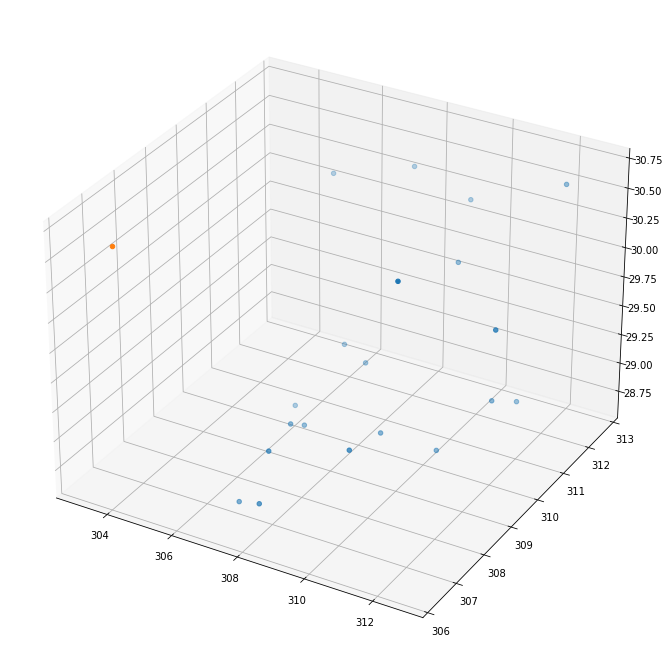

In [8]:
# 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
x = data['point_3d'][:,[0]]
y = data['point_3d'][:,[1]]
z = data['point_3d'][:,[2]]
ax.scatter3D(x, y, z)
ax.scatter3D(center[0], center[1], center[2])

# raise NotImplementedError()

# Submission

1. At the menubar, click `Kernel`$\rightarrow$ `Restart & Run All`
2. Download the zip file and upload via blackboard
   
1% deduction of late assignment total score per hour passing the deadline.

In [9]:
# import csc249
# csc249.make_submission()